We run some quick tests on our ability to use kernel functions to compute distances in high dimensions. Theory from Ramdas et. al.(2015) paper on hypothesis testing power - https://dl.acm.org/doi/10.5555/2888116.2888212#

$m$ samples from $P$ - $x_1, \cdots, x_m$ and

$P$ supported on $\mathcal{X} \subseteq \mathbb{R}^d$.

$Q$ supported on $\mathcal{Y} \subseteq \mathbb{R}^d$.

$n$ samples from $Q$ - $y_1, \cdots, y_n$

Two sample or homogeneity testing:

$$H_0: P=Q$$

$$H_1: P\neq Q$$

Non-kernel based method: $\chi^2$ statistic. Reject null hypothesis of equal proportions if the test statistic $\geq
\chi^2_{\alpha, k-1}$

Independence testing: For $(x_i, y_i)$ drawn from $P_{XY}$,

$$H_0: P_{XY} = P_X \times P_Y$$

$$H_1: P_{XY} \neq P_X \times P_Y$$

Misconception? Estimating the mean of the Gaussian is harder than deciding whether the mean is non-zero or not.

Reality? Test statistics have low estimation error that is independent of dimension, but decision problem of whether they are non-zero or not _gets harder_.

_Power_ : prob of avoiding type 2 error i.e. avoid rejecting null hypothesis when in fact it is false. Increases with:

- significance region $\alpha$ i.e. leads to larger rejection region

- sample size $n$

- difference between hypothesized value, true value i.e. difference beteween parameter values for two treatment groups.

Low power == Low detection rate. exacerbated in very high dimensions

**Kernel-based methods**

From [Francis Bach](https://www.di.ens.fr/~fbach/hbcm_2013_kertest_spm.pdf)

    - robust test statistics (provide results over larger classes of data distributions, not just Gaussian etc.)

    - apply to structure data (representation as scalars / vectors would result in loss of information - e.g. graphs, image histograms, etc.)

    Temporal segmentation: equivalent problem is reducing it to multiple tests for homogeneity between parts of a sliding window over the signal.

    > Kernel based test statistics correspond to consistent estimators of well-known information divergences between probability distributions.

For an RKHS $H_k$, the positive-definite kernel is given by:

$$k(x, y) = <\phi(x), \phi(y)>_{k}$$

(interpretation of PSD kernel as a dotproduct in Hilbert space)


Mean embedding of $P$: $\mu_P := \mathbb{E}_{x \sim P}\phi_x$

Empirical Estimate: 

$$\mu_P = \frac{1}{n} \sum_{i=1}^n \phi(x_i)$$

**Independence Testing**:

Maximum mean discrepancy (MMD):

$$\textrm{MMD}^2(P, Q) = \|\mu_P - \mu_Q \|_k^2$$


where $\|\cdot\|_k^2 = <\cdot, \cdot>_k$


Empirical (and biased) test statistic: (make unbiased by removing $k(x_i, x_i)$, $k(y_i, y_i)$)

$$\textrm{MMD}_b^2(P, Q) = \|\hat{\mu}_P - \hat{\mu}_Q \|_k^2 = \frac{1}{n^2}\sum_{i} \sum_{j} k(x_i, x_j) + \frac{1}{m^2}\sum_{i} \sum_{j} k(y_i, y_j) - \frac{2}{mn} \sum_{i}\sum_{j} k(x_i, y_j)$$


**Two-sample testing**:

$$\textrm{dCor}_n^2(X, Y)=\frac{\textrm{dCov}_n^2(X, Y)}{\sqrt{\textrm{dCov}_n^2(X, X) \textrm{dCov}_n^2(X, Y)}}$$

where $\textrm{dCov}$ is the distance covariance based on centered $L_1$ distance matrices of $X$ and $Y$.


<font color='red'> Any algorithm for two-sample testing also yields an algorithm for the latter (the reverse is also true!), so the problems are related. </font>

Typical process:
    
- calculate test statistic $T$.

- For prespecified type-1 error $\alpha$, calculate threshold $t_\alpha$ 

- reject $H_0$ if $T > t_\alpha$

For a fixed type 1 error, the test is consistent if as $n \rightarrow \infty$, the type-2 error goes to zero, or the power goes to 1.


_Empirical estimate of power_:

Fraction of successes (fraction of rejections of $H_0$ over many independent trials where each trial will involve drawing $m+n$ samples, and recomputing the test statistic for many permulations of the samples).

<font color='red'> _When a test works well, it is understood to mean that it has high power with a controlled type-1 error_ </font>

In [2]:
import numpy as np
import scipy
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import pairwise_distances
from rich.progress import track

#### Power for Hypothesis Tests

Proposed toy example by Ramdas et al. - as $d$ increases, ensure that the KL divergence between $P$ and $Q$ remains constant (two-sample testing). for independence testing, the MI should remain constant i.e. don't make a moving target for estimating power of the test when $d$ is changing. A valid choice that satisfies the above is:

$\mu_P=(0, 0, 0, \cdots, 0) \qquad \mu_Q=(1, 0, 0, \cdots, 0)$

In [3]:
def median_heuristic(xarr):
    """
    Set bandwidth $h$ for the RBF kernel to be h = med squared / 
    log n where med is the median of pairwise distances for all n
    points in xarr (scholkopf and smola 2002).
    """
    
    n_rvs = xarr.shape[0]
    n_tril = int(n_rvs * (n_rvs - 1) / 2)
    
    n = int(n_rvs * n_rvs)
    
    pds_raw = pairwise_distances(xarr)
    
    pds_tril = pds_raw[np.tril_indices(n_rvs, k=-1)]
    
    h_est = np.median(pds_tril) / np.log(n_tril)
    
    #     kernel_estimates = np.exp(- (pds**2) / (h_est**2))
    
    return pds_tril, h_est

In [4]:
dim_val=100
dd_vals = np.linspace(1, dim_val, dim_val, dtype=int)
# initialize multivariate Gaussian distribution.

all_h = np.zeros(dim_val)
all_pds = []
for i, d in enumerate(dd_vals):
#     print("Processing dimension, ", d)
    x_dist = scipy.stats.multivariate_normal(mean=2.5*np.ones(d),
                                            cov=np.eye(d))
    
    rvs_d = x_dist.rvs(size=50)
    
    if d == 1:
        rvs_d = rvs_d.reshape(-1, 1)
    
    pds, h_est = median_heuristic(rvs_d)
    
    
    all_pds.append(pds)
    all_h[i] = h_est

In [5]:
np.set_printoptions(precision=3)
print(np.get_printoptions())

{'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 3, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': False}


In [6]:
all_pds[1].shape

(1225,)

How does the ratio between pairwise distances and bandwidth change?

In [7]:
kd_dim001 = np.sort(np.exp(- (all_pds[0]**2) / (all_h[0]**2)))
kd_dim025 = np.sort(np.exp(- (all_pds[24]**2) / (all_h[24]**2)))
kd_dim100 = np.sort(np.exp(- (all_pds[-1]**2) / (all_h[-1]**2)))

In [8]:
kd_dim001.shape, kd_dim100.shape

((1225,), (1225,))

In [9]:
import matplotlib.pyplot as plt

In [10]:
kd_dim025.min(), kd_dim025.max()

(1.3440173024350117e-44, 2.067874891185835e-05)

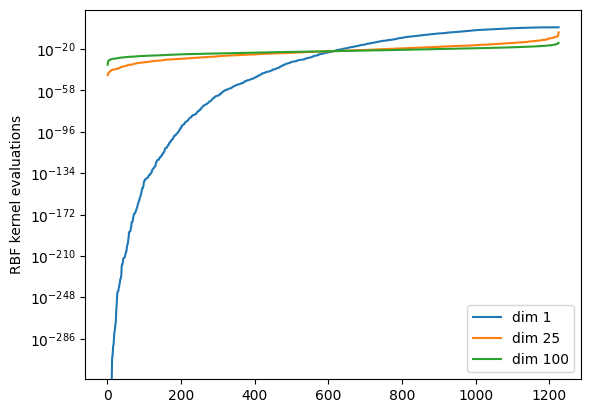

In [11]:
plt.semilogy(np.linspace(1, 1225, 1225), 
         kd_dim001, 
         label="dim 1")
plt.semilogy(np.linspace(1, 1225, 1225), 
         kd_dim025, 
         label="dim 25")
plt.semilogy(np.linspace(1, 1225, 1225), 
         kd_dim100, 
         label="dim 100")
plt.ylabel("RBF kernel evaluations")
# plt.ylim(0, 0.01)
plt.legend()

The above may not be reflective of estimates of kernel as the posterior distribution is updated. How does it translate to a high-dim Gaussian posterior with multiple modes?

In [ ]:
# x_dist = scipy.stats.multivariate_normal(mean=np.zeros(5000),
#                                             cov=np.eye(5000))
# rvs_d = x_dist.rvs(size=50)
# pds = pairwise_distances(rvs_d).flatten()

# pds.shape

In [ ]:
# np.median(pds)

In [ ]:
h_est

In [ ]:
# pairwise_distances(rvs_d).shape

#### Behaviour of Common Kernels in high-dimensions

(what happens to the repulsive term? As the bandwidth goes to zero, the SVGD update reduces to estimation of MAP, and particles would collapse into local modes) - we will estimate distances for many samples drawn from the same Gaussian distribution.